In [1]:
import matplotlib.pyplot as plt
import torch
from basic_unet import UNet
from dataset import BratsDataset
from torchvision import transforms
from pathlib import Path
import hdm

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = UNet(in_channels=4, out_channels=1)
state_dict = torch.load('models/3_basic_unet_flat_criterion_279_0.00000.pth')
model.load_state_dict(state_dict)
model = model.to(device)

In [3]:
transform = transforms.Compose([
    transforms.Normalize([0.5, 0.5, 0.5, 0.5], [0.5, 0.5, 0.5, 0.5])
])
dataset = BratsDataset(Path('data/processed/'), transform)

In [4]:
sample = dataset.get_sample('Brats18_2013_17_1', 'L1')
segment = sample['segment']
image = sample['input']

In [5]:
explainer = hdm.HausdorffDistanceMasks(240, 240)
explainer.generate_masks(circle_size=15, offset=5, normalize=True)

results = []
# the list item order has to match with the modalities returned by the dataset
for channel, modality in enumerate(['t1', 't1ce', 't2', 'flair']):
    result = explainer.explain(model, image, segment, device, channel=channel)
    results.append(result)

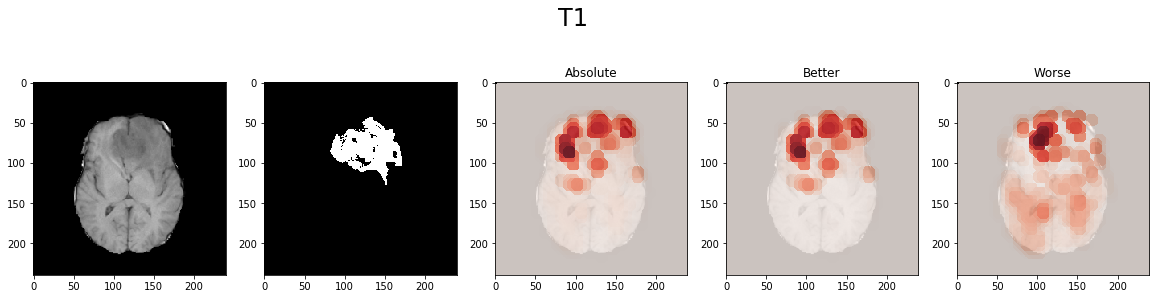

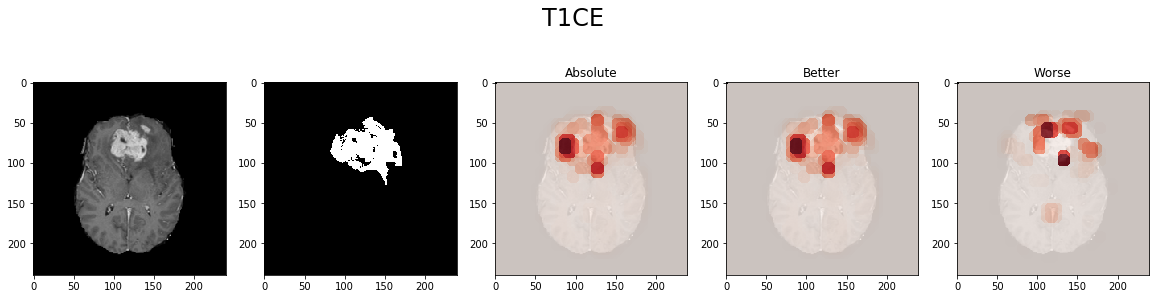

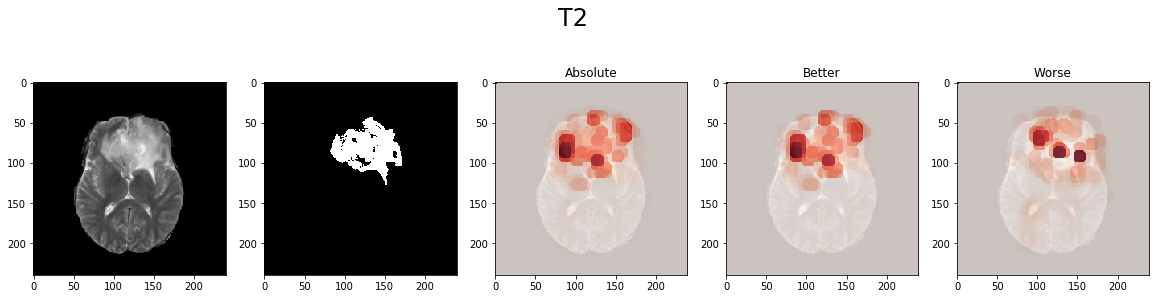

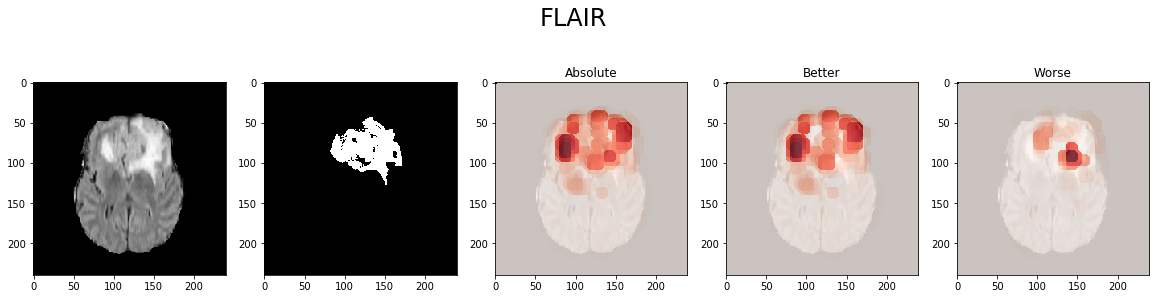

In [6]:
for channel, modality in enumerate(['t1', 't1ce', 't2', 'flair']):
    result = results[channel]
    absolute = result.circle_map(hdm.ABSOLUTE)
    better = result.circle_map(hdm.BETTER_ONLY)
    worse = result.circle_map(hdm.WORSE_ONLY)

    absolute_distances = result.distances(hdm.ABSOLUTE)
    better_distances = result.distances(hdm.BETTER_ONLY)
    worse_distances = result.distances(hdm.WORSE_ONLY)

    figure, plots = plt.subplots(1, 5, figsize=(20, 5))
    figure.suptitle(modality.upper(), fontsize=24)

    plots[0].imshow(image[channel], cmap='gray')
    plots[1].imshow(segment, cmap='gray')

    plots[2].imshow(image[channel], cmap='gray')
    plots[2].imshow(absolute, alpha=0.8, cmap='Reds')
    plots[2].set_title(f'Absolute')

    plots[3].imshow(image[channel], cmap='gray')
    plots[3].imshow(better, alpha=0.8, cmap='Reds')
    plots[3].set_title(f'Better')

    plots[4].imshow(image[channel], cmap='gray')
    plots[4].imshow(worse, alpha=0.8, cmap='Reds')
    plots[4].set_title(f'Worse')